# Quantitative Risk Management

Additional knowledge about risk management and efficient library to be computed.

## Part 1: Risk and Return Recap

Calculate the efficient frontier using the `pypfopt` library.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
portfolio_df = pd.read_csv('EfficientFrontierPortfoliosSlim.csv')
portfolio_df.head()

,AAPL weight,MSFT weight,XOM weight,JNJ weight,JPM weight,AMZN weight,GE weight,FB weight,T weight,Returns,Volatility
0,0.000053,0.263110,0.007022,0.040087,0.000027,0.024316,0.355899,0.299400,0.010087,0.127453,0.171565
1,0.042360,0.034922,0.079355,0.043057,0.001435,0.202032,0.225924,0.362324,0.008590,0.138614,0.182723
2,0.207824,0.002132,0.005982,0.041657,0.007498,0.406642,0.064929,0.229260,0.034075,0.155952,0.201185
3,0.096565,0.016775,0.118409,0.037725,0.020013,0.045195,0.512282,0.153015,0.000020,0.118787,0.148958
4,0.131309,0.002733,0.002360,0.047573,0.050633,0.289410,0.313717,0.157123,0.005141,0.138304,0.171473


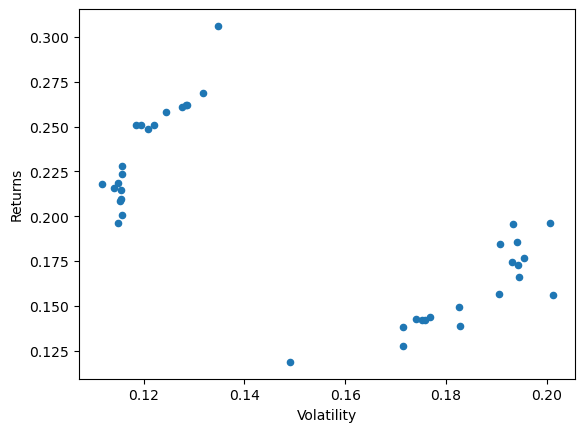

In [3]:
# Plotting the graph of (returns, volatility)
portfolio_df.plot.scatter(y="Returns", x="Volatility")
plt.show()

In [4]:
return_df = pd.read_csv('crisis_portfolio.csv', parse_dates=['Date'], index_col='Date', infer_datetime_format=True)
return_df.head()

,Citibank,Morgan Stanley,Goldman Sachs,J.P. Morgan
Date,,,,
2004-12-31,481.799988,55.520000,104.040001,39.009998
2005-01-03,482.700012,55.900002,104.949997,39.150002
2005-01-04,478.600006,55.299999,104.269997,38.410000
2005-01-05,484.600006,54.980000,103.800003,38.490002
2005-01-06,489.299988,56.279999,105.230003,38.709999


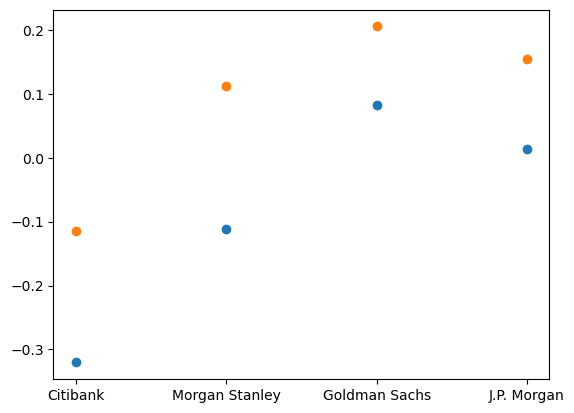

In [5]:
# Import the mean_historical_return method
from pypfopt.expected_returns import mean_historical_return

# Compute the annualized average historical return by the mean_historical_return function
mean_returns = mean_historical_return(return_df, frequency = 252)
# Compute the annualized average historical return using pandas utilities
mean_returns_pandas = ((1 + return_df.pct_change().mean()) ** 252) - 1

# Plot the annualized average historical return
plt.plot(mean_returns, linestyle = 'None', marker = 'o', label='pypfopt')
plt.plot(mean_returns_pandas, linestyle = 'None', marker = 'o', label='pandas')
plt.show()

**Covariance shrinkage**

Portfolio optimization relies upon an unbiased and efficient estimate of asset covariance. Although sample covariance is unbiased, it is not efficient--extreme events tend to be overweighted.

One approach to alleviate this is through "covariance shrinkage", where large errors are reduced ('shrunk') to improve efficiency.

In [6]:
# Import the CovarianceShrinkage object
from pypfopt.risk_models import CovarianceShrinkage

# Create the CovarianceShrinkage instance variable
cs = CovarianceShrinkage(return_df)

# Compute the sample covariance matrix of returns
sample_cov = return_df.pct_change().cov() * 252

# Compute the efficient covariance matrix of returns
e_cov = cs.ledoit_wolf()

# Display both the sample covariance_matrix and the efficient e_cov estimate
print("Sample Covariance Matrix\n", sample_cov, "\n")
print("Efficient Covariance Matrix\n", e_cov, "\n")

Sample Covariance Matrix
                 Citibank  Morgan Stanley  Goldman Sachs  J.P. Morgan
Citibank        0.536214        0.305045       0.217993     0.269784
Morgan Stanley  0.305045        0.491993       0.258625     0.218310
Goldman Sachs   0.217993        0.258625       0.217686     0.170937
J.P. Morgan     0.269784        0.218310       0.170937     0.264315 

Efficient Covariance Matrix
                 Citibank  Morgan Stanley  Goldman Sachs  J.P. Morgan
Citibank        0.527505        0.288782       0.206371     0.255401
Morgan Stanley  0.288782        0.485642       0.244837     0.206671
Goldman Sachs   0.206371        0.244837       0.225959     0.161823
J.P. Morgan     0.255401        0.206671       0.161823     0.270102 



In [7]:
# Create a dictionary of time periods (or 'epochs')
epochs = { 'before' : {'start': '2005-01-01', 'end': '2006-12-31'},
           'during' : {'start': '2007-01-01', 'end': '2008-12-31'},
           'after'  : {'start': '2009-01-01', 'end': '2010-12-31'}
         }

# Compute the efficient covariance for each epoch
e_covs = {}
for x in epochs.keys():
    sub_price = return_df.loc[epochs[x]['start']:epochs[x]['end']]
    e_covs[x] = CovarianceShrinkage(sub_price).ledoit_wolf()

# Display the efficient covariance matrices for all epochs
for x in epochs.keys():
    print(x)
    display(e_covs[x])

before


,Citibank,Morgan Stanley,Goldman Sachs,J.P. Morgan
Citibank,0.018149,0.013789,0.013183,0.013523
Morgan Stanley,0.013789,0.043021,0.030559,0.016525
Goldman Sachs,0.013183,0.030559,0.044482,0.018237
J.P. Morgan,0.013523,0.016525,0.018237,0.024182


during


,Citibank,Morgan Stanley,Goldman Sachs,J.P. Morgan
Citibank,0.713035,0.465336,0.323977,0.364848
Morgan Stanley,0.465336,0.994390,0.434874,0.298613
Goldman Sachs,0.323977,0.434874,0.408773,0.224668
J.P. Morgan,0.364848,0.298613,0.224668,0.422516


after


,Citibank,Morgan Stanley,Goldman Sachs,J.P. Morgan
Citibank,0.841156,0.344939,0.252684,0.356788
Morgan Stanley,0.344939,0.388839,0.231624,0.279727
Goldman Sachs,0.252684,0.231624,0.244539,0.223740
J.P. Morgan,0.356788,0.279727,0.223740,0.382494


*"The breakdown of the 2005 - 2010 period into sub-periods shows how the portfolio's risk increased during the crisis, and this changed the risk-return trade-off after the crisis."*

In [8]:
returns_during = mean_historical_return(return_df.loc[epochs['during']['start']:epochs['during']['end']], frequency=252)
returns_during

Citibank         -0.652236
Morgan Stanley   -0.557410
Goldman Sachs    -0.352148
J.P. Morgan      -0.190451
dtype: float64

In [9]:
ecov_during = e_covs['during']
ecov_during

,Citibank,Morgan Stanley,Goldman Sachs,J.P. Morgan
Citibank,0.713035,0.465336,0.323977,0.364848
Morgan Stanley,0.465336,0.994390,0.434874,0.298613
Goldman Sachs,0.323977,0.434874,0.408773,0.224668
J.P. Morgan,0.364848,0.298613,0.224668,0.422516


OrderedDict([('Citibank', 0.0), ('Morgan Stanley', 0.0), ('Goldman Sachs', 0.517989947659934), ('J.P. Morgan', 0.482010052340066)])


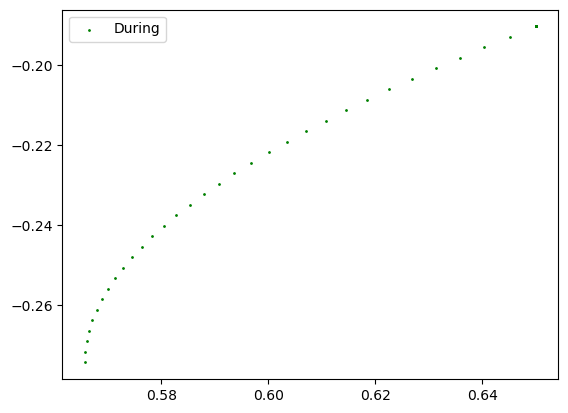

In [10]:
from pypfopt.cla import CLA

# Initialize the Crtical Line Algorithm object
efficient_portfolio_during = CLA(returns_during, ecov_during)

# Find the minimum volatility portfolio weights and display them
print(efficient_portfolio_during.min_volatility())

# Compute the efficient frontier
(ret, vol, weights) = efficient_portfolio_during.efficient_frontier()

# Add the frontier to the plot showing the 'before' and 'after' frontiers
plt.scatter(vol, ret, s = 4, c = 'g', marker = '.', label = 'During')
plt.legend()
plt.show()

## Part 2: Goal-oriented risk management

Suppose there are 2 options for hotel reservations for vacation

- **Pay in advance, before stay**: Low room rate (500\$) and **non-refundable** (i.e., cancellation fee = 100% of room rate).
- **Pay after arrival**: High room rate (550\$) and **partially refundable** (i.e., cancellation fee = 20% of room rate).

**Deciding between options**

Things that determine the decision include:
- Chance of negative shock, or **probability of loss**: For example, you got illness, travel disruption or bad weather condition on the arrival date.
- **Loss associated with shock**: using VaR, CVaR
- **Desire to avoid shock**: Your characteristics is to take risk and save money, or being safe.

**Risk exposure**

Risk exposure = (probability of loss) x (loss measure)

For example:
- There is 10% chance of canceling vacation.
- In non-refundable choice:
    - Total cost: 500\$
    - Loss = 500\$ = VaR(0.9)
- In refundable choice:
    - Total cost: 550\$
    - Loss: 110\$ = VaR(0.9)
    
Therefore:
- Non-refundable exposure = 0.1 x 500 = 50
- Partially refundable exposure = 0.1 x 110 = 11
- *Difference in risk exposure*: 50 - 11 = 39
- Total price difference between offers: 550 - 500 = 50

**Desire to avoid shock (risk tolerance or risk appetite)**
- *Risk-neutral*: only expected values matter => choose non-refundable
- *Risk-averse*: uncertainty carries a cost => choose refundable

A common risk exposure distribution is *Student's t*.

In [11]:
losses = -return_df.pct_change().dropna()["Citibank"]
losses.head()

Date
2005-01-03   -0.001868
2005-01-04    0.008494
2005-01-05   -0.012537
2005-01-06   -0.009699
2005-01-07    0.005722
Name: Citibank, dtype: float64

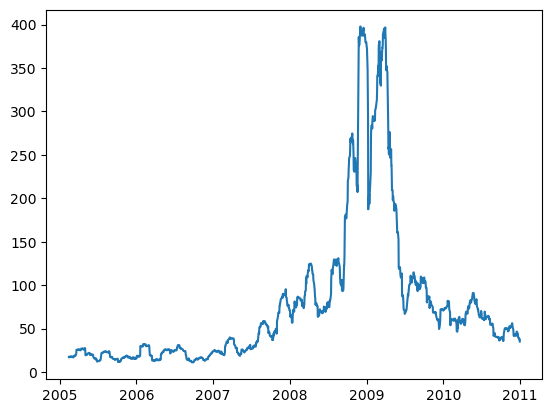

In [12]:
# Import the Student's t-distribution
from scipy.stats import t

# Create rolling window parameter list
mu = losses.rolling(30).mean()
sigma = losses.rolling(30).std()
rolling_parameters = [(29, mu[i], s) for i,s in enumerate(sigma)]

# Compute the 99% VaR array using the rolling window parameters
VaR_99 = np.array( [ t.ppf(0.99, *params) 
                    for params in rolling_parameters ] )

# Plot the minimum risk exposure over the 2005-2010 time period
plt.plot(losses.index, 0.01 * VaR_99 * 100000)
plt.show()

The graph is generated by taking samples from Student's t distribution with mean and standard deviation taking from observation within 30-day period, then compute the VaR(0.99) from the distribution.

In [13]:
# Fit the Student's t distribution to crisis losses
p = t.fit(losses)

# Compute the VaR_99 for the fitted distribution
VaR_99 = t.ppf(0.99, *p)

# Use the fitted parameters and VaR_99 to compute CVaR_99
tail_loss = t.expect( lambda y: y, args = (p[0],), loc = p[1], scale = p[2], lb = VaR_99 )
CVaR_99 = (1 / (1 - 0.99)) * tail_loss
print(CVaR_99)

0.8763612870943699


The computation of CVaR in this notebook is a bit different from the one in the first notebook. It can be used as an alternative.

**Select portfolio that minimize CVaR**

In [14]:
returns = return_df.pct_change().dropna()
returns.head()

,Citibank,Morgan Stanley,Goldman Sachs,J.P. Morgan
Date,,,,
2005-01-03,0.001868,0.006844,0.008747,0.003589
2005-01-04,-0.008494,-0.010734,-0.006479,-0.018902
2005-01-05,0.012537,-0.005787,-0.004507,0.002083
2005-01-06,0.009699,0.023645,0.013776,0.005716
2005-01-07,-0.005722,-0.003909,-0.004276,-0.008008


In [15]:
# Import the EfficientCVaR class
from pypfopt.efficient_frontier import EfficientCVaR

# Create the efficient frontier for CVaR minimization
ec = EfficientCVaR(None, returns)

# Find the cVaR-minimizing portfolio weights at the default 95% confidence level
optimal_weights = ec.min_cvar()

# Map the values in optimal_weights to the bank names
names = {0: 'Citibank', 1: 'Morgan Stanley', 2: 'Goldman Sachs', 3: 'J.P. Morgan'}
optimal_weights = { names[i] : optimal_weights[i] for i in optimal_weights}

# Display the optimal weights
print(optimal_weights)

{'Citibank': 1.2e-14, 'Morgan Stanley': 1.4e-15, 'Goldman Sachs': 0.669324359403484, 'J.P. Morgan': 0.3306756405965026}


In [16]:
# Initialize the efficient portfolio dictionary
ec_dict = {}

# For each epoch, assign an efficient frontier cvar instance to ec
for x in ['before', 'during', 'after']: 
    returns_epoch = returns.loc[epochs[x]['start']:epochs[x]['end']]
    ec_dict[x] = EfficientCVaR(None, returns_epoch)

# Initialize the dictionary of optimal weights
opt_wts_dict = {}

# Find and display the CVaR-minimizing portfolio weights at the default 95% confidence level
for x in ['before', 'during', 'after']:
    opt_wts_dict[x] = ec_dict[x].min_cvar()
    # map bank names to optimal weights
    opt_wts_dict[x] = {names[i] : opt_wts_dict[x][i] for i in opt_wts_dict[x]}
    
# Portfolio chosen by minimum volatility
min_vol_dict = {
    'before': {
        'Citibank': 0.657653371196737,
        'Morgan Stanley': 0.0480059867221236,
        'Goldman Sachs': 0.0403774713630865,
        'J.P. Morgan': 0.253963170718053
    },
    'during': {
        'Citibank': 0.0,
        'Morgan Stanley': 0.0,
        'Goldman Sachs': 0.5179899476599342,
        'J.P. Morgan': 0.4820100523400658},
    'after': {
        'Citibank': 0.0,
        'Morgan Stanley': 0.0343318420598168,
        'Goldman Sachs': 0.8630043657391508,
        'J.P. Morgan': 0.1026637922010324
    }
}
# Compare the CVaR-minimizing weights to the minimum volatility weights for the 'before' epoch
print("CVaR:\n", opt_wts_dict['before'], "\n")
print("Min Vol:\n", min_vol_dict['before'], "\n")

CVaR:
 {'Citibank': 0.4609477943301659, 'Morgan Stanley': 0.0549059865334676, 'Goldman Sachs': 0.0153721405973319, 'J.P. Morgan': 0.4687740785390346} 

Min Vol:
 {'Citibank': 0.657653371196737, 'Morgan Stanley': 0.0480059867221236, 'Goldman Sachs': 0.0403774713630865, 'J.P. Morgan': 0.253963170718053} 



In [17]:
epochs['before']

{'start': '2005-01-01', 'end': '2006-12-31'}

**Hedging (reading)**

A hedge, in its simplest form, is an investment intended to move in the opposite direction of an asset in your portfolio that you consider to be at risk. A hedge provides inverse exposure.

## Part 3: Estimating and identifying risk

**Parametric Estimation**

- *Fitting a distribution* on data according to error-minimizing criteria.
- *Goodness of fit*: How well does an estimated distribution fit the data?
    - By visualization
    - By Anderson-Darling test:
        - Null hypothesis: Data are normally distributed.
        - Test `statistic` rejects Normal distribution if larger than `critical_values`.
    - By `skewtest`:
        - Test how far data is from symmetric distribution.
        - Null hypothesis: data distribution has no skewness (symmetric)
        - Statistically significant => use distribution class with skewness

In [18]:
# Import the Normal distribution and skewness test from scipy.stats
from scipy.stats import norm, anderson

# Fit portfolio losses to the Normal distribution
params = norm.fit(losses)

# Compute the 95% VaR from the fitted distribution, using parameter estimates
VaR_95 = norm.ppf(0.95, *params)
print("VaR_95, Normal distribution: ", VaR_95)

# Test the data for Normality
print("Anderson-Darling test result: ", anderson(losses))

VaR_95, Normal distribution:  0.07633477324193982
Anderson-Darling test result:  AndersonResult(statistic=115.89711964840649, critical_values=array([0.574, 0.654, 0.785, 0.916, 1.089]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))


The Anderson-Darling test value of 115.89 exceeds the 99% critical value of 1.089 by a large margin, indicating that the Normal distribution is not a good fit.

In [19]:
# Import the skew-normal distribution and skewness test from scipy.stats
from scipy.stats import skewnorm, skewtest

# Test the data for skewness
print("Skewtest result: ", skewtest(losses))

# Fit the portfolio loss data to the skew-normal distribution
params = skewnorm.fit(losses)

# Compute the 95% VaR from the fitted distribution, using parameter estimates
VaR_95 = skewnorm.ppf(0.95, *params)
print("VaR_95 from skew-normal: ", VaR_95)

Skewtest result:  SkewtestResult(statistic=-18.05341222493315, pvalue=7.41640357398957e-73)
VaR_95 from skew-normal:  0.07195966155487526


Similarly, skewtest results show the Normal distribution estimates cannot be relied upon.

<AxesSubplot:xlabel='Citibank', ylabel='Count'>

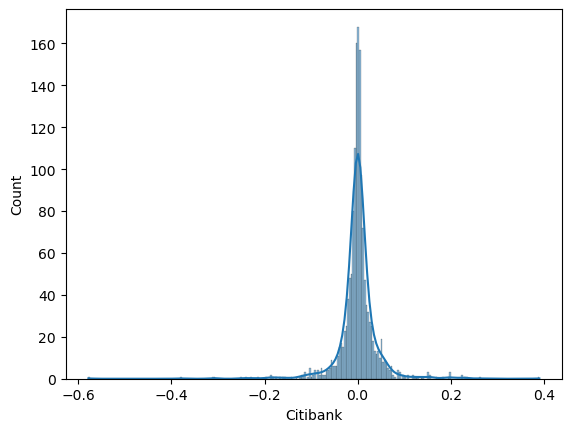

In [20]:
sns.histplot(losses, kde=True)

**Monte Carlo simulation**: Taken from the previous course.

**Structural breaks**

Loss distribution is non-stationary (distribution is likely to change over time). To tackle this problem, assume specific points in time for change:
- Break up data into sub-periods.
- Within each sub-period, assume stationarity.

*Chow Test*:

- Test for existence of structural break given linear model
- Null hypothesis: no break
- Requires 3 OLS (Ordinary Least Squared) regressions
    - Regression for entire period
    - Two regressions, before and after break

In [21]:
mort_del = pd.read_csv('mortgage_delinquency.csv', parse_dates=['Date'], index_col='Date')
mort_del.head()

,Mortgage Delinquency Rate
Date,
2005-03-31,0.0155
2005-06-30,0.0159
2005-09-30,0.0163
2005-12-31,0.0161
2006-03-31,0.0162


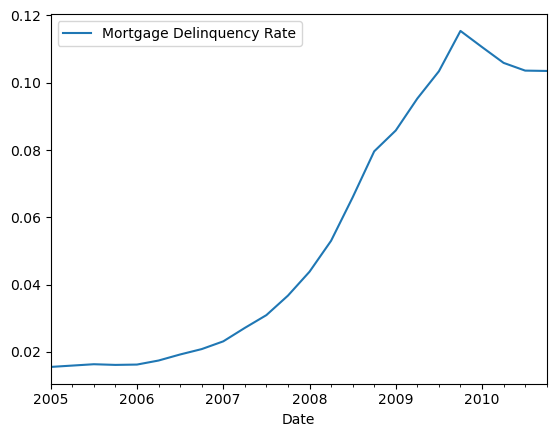

In [22]:
mort_del.plot()
plt.show()

In [23]:
sample_portfolio_return = return_df['Citibank'].pct_change().dropna()
sample_portfolio_return.head()

Date
2005-01-03    0.001868
2005-01-04   -0.008494
2005-01-05    0.012537
2005-01-06    0.009699
2005-01-07   -0.005722
Name: Citibank, dtype: float64

In [24]:
port_q_min = sample_portfolio_return.resample('Q').min()
port_q_min.head()

Date
2005-03-31   -0.028846
2005-06-30   -0.018278
2005-09-30   -0.030590
2005-12-31   -0.012252
2006-03-31   -0.046934
Freq: Q-DEC, Name: Citibank, dtype: float64

<AxesSubplot:xlabel='Date'>

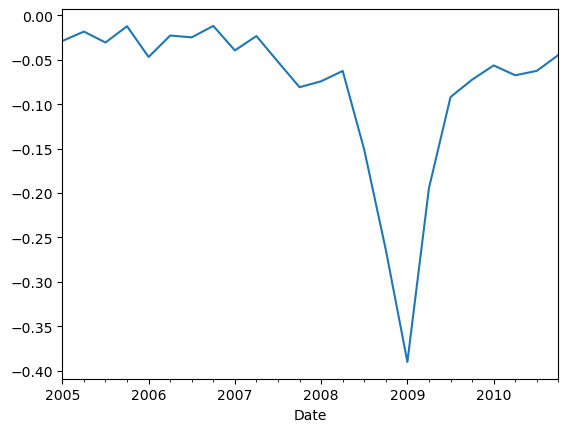

In [25]:
port_q_min.plot()

In [26]:
# Import the statsmodels API to be able to run regressions
import statsmodels.api as sm

# Add a constant to the regression
mort_del = sm.add_constant(mort_del)

# Regress quarterly minimum portfolio returns against mortgage delinquencies
result = sm.OLS(port_q_min, mort_del).fit()

# Retrieve the sum-of-squared residuals
ssr_total = result.ssr
print("Sum-of-squared residuals, 2005-2010: ", ssr_total)

Sum-of-squared residuals, 2005-2010:  0.14534884262994477


In [27]:
before_mort_del = mort_del.loc[:'2008-06-30']
after_mort_del = mort_del.loc['2008-06-30':]

before_port_q_min = port_q_min.loc[:'2008-06-30']
after_port_q_min = port_q_min.loc['2008-06-30':]

In [28]:
# Add intercept constants to each sub-period 'before' and 'after'
before_with_intercept = sm.add_constant(before_mort_del)
after_with_intercept  = sm.add_constant(after_mort_del)

# Fit OLS regressions to each sub-period
r_b = sm.OLS(before_port_q_min, before_with_intercept).fit()
r_a = sm.OLS(after_port_q_min,  after_with_intercept).fit()

# Get sum-of-squared residuals for both regressions
ssr_before = r_b.ssr
ssr_after = r_a.ssr
# Compute and display the Chow test statistic
numerator = ((ssr_total - (ssr_before + ssr_after)) / 2)
denominator = ((ssr_before + ssr_after) / (24 - 4))
print("Chow test statistic: ", numerator / denominator)

Chow test statistic:  3.0567793791175126


To identify structural break, one can examine **volatility** rather than trend.

<AxesSubplot:xlabel='Date'>

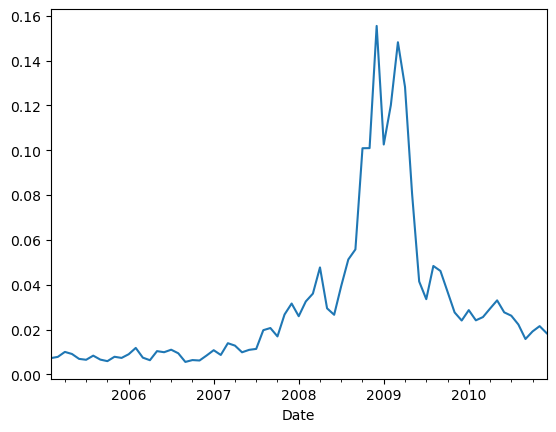

In [29]:
volatility = sample_portfolio_return.rolling(30).std().dropna()
vol_mean = volatility.resample("M").mean()
vol_mean.plot()

## Part 4: Advanced risk management

**Extreme value theory**

- *Extreme velue theory*: statistical distribution of extreme values
- **Block maxima**:
    - Break period into sub-periods
    - Form blocks from each sub-period
    - Set of block maxima => dataset
- **Peak over threshold (POT)**:
    - Find all losses over a given level
    - Set of such losses => dataset
    
- Generalized Extreme Value Distribution (GEV): Distribution of maxima of data

- VaR or CVaR estimate over extreme values is often used in the banking and insurance sectors to cover losses, which is an integral part of enterprise risk management. It is a regulatory requirement that banks keep **reserve requirements**, which are the amount of cash that financial institutions must have, in their vaults or at the closest Federal Reserve bank, in line with deposits made by their customers.

*For example:* Given initial portfolio value at $1 million. We would like to know the reserve requirement at a 99% confidence level and a one week horizon.

- VaR(0.99) from GEV Distribution to get maximum loss over one week at 99% confidence
- Reserve requirement = portfolio value x VaR(0.99)

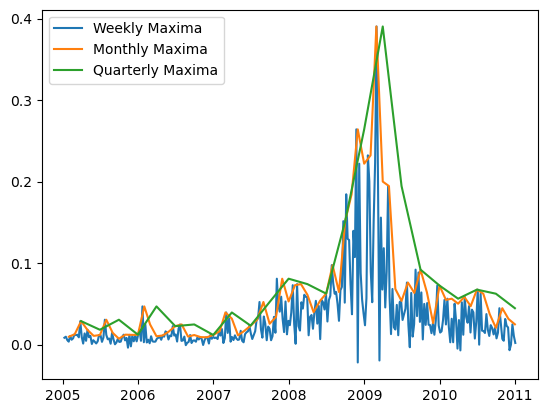

In [30]:
# Resample the data into weekly blocks
weekly_maxima = losses.resample("W").max()

# Plot the resulting weekly maxima
plt.plot(weekly_maxima, label = "Weekly Maxima")
plt.legend()

# Resample the data into monthly blocks
monthly_maxima = losses.resample("M").max()

# Plot the resulting monthly maxima
plt.plot(monthly_maxima, label = "Monthly Maxima")
plt.legend()

# Resample the data into quarterly blocks
quarterly_maxima = losses.resample("Q").max()

# Plot the resulting quarterly maxima
plt.plot(quarterly_maxima, label = "Quarterly Maxima")
plt.legend()

plt.show()

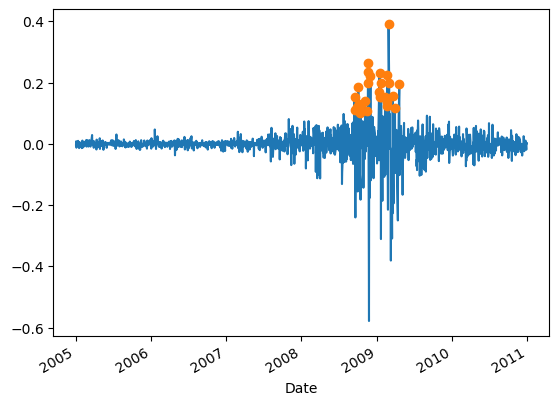

In [31]:
# Plot the log daily losses of GE over the period 2007-2009
losses.plot()

# Find all daily losses greater than 10%
extreme_losses = losses[losses > 0.1]

# Scatter plot the extreme losses
extreme_losses.plot(style='o')
plt.show()

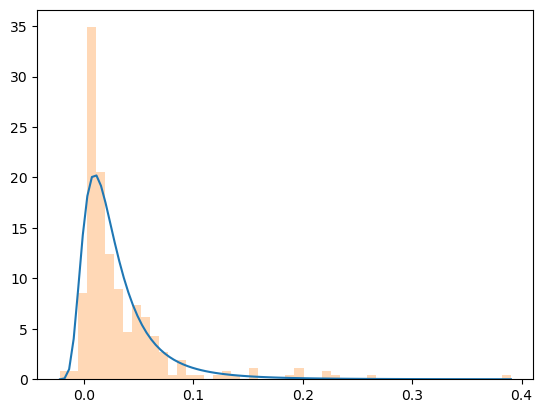

In [32]:
from scipy.stats import genextreme

# Fit extreme distribution to weekly maximum of losses
fitted = genextreme.fit(weekly_maxima)

# Plot extreme distribution with weekly max losses historgram
x = np.linspace(min(weekly_maxima), max(weekly_maxima), 100)
plt.plot(x, genextreme.pdf(x, *fitted))
plt.hist(weekly_maxima, 50, density = True, alpha = 0.3)
plt.show()

In [33]:
# Fit the GEV distribution to the maxima
p = genextreme.fit(weekly_maxima)

# Compute the 99% VaR (needed for the CVaR computation)
VaR_99 = genextreme.ppf(0.99, *p)

# Compute the 99% CVaR estimate
CVaR_99 = (1 / (1 - 0.99)) * genextreme.expect(lambda x: x, 
           args=(p[0],), loc = p[1], scale = p[2], lb = VaR_99)

# Display the covering loss amount
print("Reserve amount: ", 1000000 * CVaR_99)

Reserve amount:  259517.35820950055


**Non-parametric estimation with kernel density estimation**

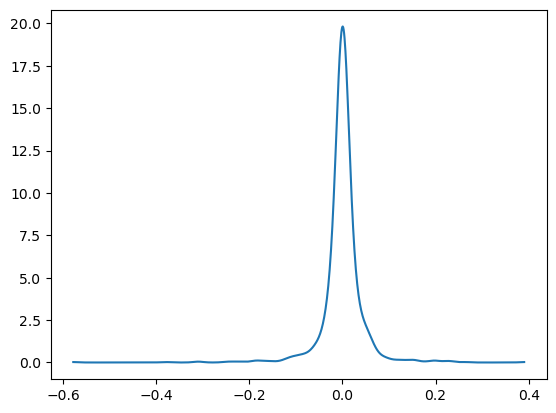

In [34]:
from scipy.stats import gaussian_kde

kde = gaussian_kde(losses)
loss_range = np.linspace(np.min(losses), np.max(losses), 1000)
plt.plot(loss_range, kde.pdf(loss_range))
plt.show()

In [35]:
sample = kde.resample(size=1000)
VaR_99 = np.quantile(sample, 0.99)
print("VaR_99 from KDE:", VaR_99)

VaR_99 from KDE: 0.18134754680465912


**Neural network risk management**


In training:
- Input: Asset prices
- Output: Portfolio weights
- Objective: Minimize the difference between output and pre-existing "best" portfolio weights

In usage:
- Input: new, unseen asset prices
- Output: predicted "best" portfolio weights for new asset prices.

In [ ]:
# Sample code, but cannot run in Mac due to setup problems
from tensorflow.keras import Sequential, Dense

# Set the input and output data
training_input = prices.drop('Morgan Stanley', axis=1)
training_output = prices['Morgan Stanley']

# Create and train the neural network with two hidden layers
model = Sequential()
model.add(Dense(16, input_dim=8, activation='sigmoid'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1))

model.compile(loss='mean_squared_logarithmic_error', optimizer='rmsprop')
model.fit(training_input, training_output, epochs=100)

# Scatter plot of the resulting model prediction
plt.scatter(training_output, model.predict(training_input))
plt.show()